In [1]:
import os
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image

In [2]:
def parse_annotations(annotations_dir):
    class_names = []

    for filename in os.listdir(annotations_dir):
        if filename.endswith('.xml'):
            xml_file = os.path.join(annotations_dir, filename)
            tree = ET.parse(xml_file)
            root = tree.getroot()

            for obj in root.findall('object'):
                class_name = obj.find('name').text
                class_names.append(class_name)

    unique_classes = list(set(class_names))
    class_name_to_label = {class_name: idx for idx, class_name in enumerate(unique_classes)}
    number_of_classes = len(unique_classes)

    return class_name_to_label, number_of_classes

# Path to annotations directories
training_annotations_dir = './documents/datasets/bloodCells/Complete-Blood-Cell-Count-Dataset-master/training/Annotations'
testing_annotations_dir = './Documents/Datasets/bloodCells/Complete-Blood-Cell-Count-Dataset-master/Testing/Annotations'

# Parse annotations to get class name mapping and number of classes for training dataset
train_class_name_to_label, train_number_of_classes = parse_annotations(training_annotations_dir)
print("Training - Number of Classes:", train_number_of_classes)
print("Training - Unique Classes:", list(train_class_name_to_label.keys()))

# Parse annotations to get class name mapping and number of classes for testing dataset
test_class_name_to_label, test_number_of_classes = parse_annotations(testing_annotations_dir)
print("Testing - Number of Classes:", test_number_of_classes)
print("Testing - Unique Classes:", list(test_class_name_to_label.keys()))

# Use the same class_name_to_label mapping for both training and testing datasets
class_name_to_label = train_class_name_to_label  # Assuming the same class mapping is used for both

# Ensure consistent label mapping by inspecting and comparing train_class_name_to_label and test_class_name_to_label

Training - Number of Classes: 3
Training - Unique Classes: ['Platelets', 'WBC', 'RBC']
Testing - Number of Classes: 3
Testing - Unique Classes: ['Platelets', 'WBC', 'RBC']


In [3]:
# Path to image directory
train_dataset_path = './documents/datasets/bloodCells/Complete-Blood-Cell-Count-Dataset-master/training/Images'

# Create training data by associating image paths with their labels
training_data = []

for filename in os.listdir(train_dataset_path):
    if filename.endswith('.jpg'):
        image_path = os.path.join(train_dataset_path, filename)
        annotation_filename = filename.replace('.jpg', '.xml')
        annotation_path = os.path.join(training_annotations_dir, annotation_filename)

        if os.path.exists(annotation_path):
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            obj = root.find('object')
            if obj is not None:
                class_name = obj.find('name').text
                label = class_name_to_label[class_name]
                training_data.append((image_path, label))


In [4]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, data, annotations_dir, class_name_to_label, transform=None):
        self.data = data
        self.annotations_dir = annotations_dir
        self.class_name_to_label = class_name_to_label
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, label


In [5]:
# Define transformations for the images
# Normalization -> image = (image - mean) / std

mean = [0.7365, 0.6955, 0.7137]
std= [0.0598, 0.1014, 0.0760]

train_transforms = transforms.Compose([
    transforms.Resize((640, 480)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
    transforms.Resize((640, 480)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [6]:
# Initialize CustomImageDataset with training_data
train_custom_dataset = CustomImageDataset(training_data, training_annotations_dir, class_name_to_label, transform=train_transforms)

In [7]:
# Create a DataLoader to load the dataset in batches

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_custom_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Iterate through batches in the DataLoader
# Process each batch of images and labels (perform training/validation, etc.)

for images, labels in train_loader:
    print(f"Batch Size: {images.size(0)}")
    print("Labels:", labels)

Batch Size: 32
Labels: tensor([1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
Batch Size: 32
Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
Batch Size: 32
Labels: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
Batch Size: 32
Labels: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 0, 2])
Batch Size: 32
Labels: tensor([2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 0])
Batch Size: 32
Labels: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
Batch Size: 32
Labels: tensor([2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 1, 2, 2, 2, 2, 2])
Batch Size: 32
Labels: tensor([2, 2, 0, 2, 2, 2,

In [9]:
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, labels in train_loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
        
    mean /= total_images_count
    std /= total_images_count
    
    return mean, std

In [10]:
get_mean_and_std(train_loader)

(tensor([-0.4942, -0.2762, -0.3685]), tensor([2.5338, 1.6423, 2.0438]))

In [11]:
# Path to image directory
test_dataset_path = './Documents/Datasets/bloodCells/Complete-Blood-Cell-Count-Dataset-master/Testing/Images'

# Create training data by associating image paths with their labels
test_data = []

for filename in os.listdir(test_dataset_path):
    if filename.endswith('.jpg'):
        image_path = os.path.join(test_dataset_path, filename)
        annotation_filename = filename.replace('.jpg', '.xml')
        annotation_path = os.path.join(testing_annotations_dir, annotation_filename)

        if os.path.exists(annotation_path):
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            obj = root.find('object')
            if obj is not None:
                class_name = obj.find('name').text
                label = class_name_to_label.get(class_name, -1)  # Use default label if not found
                test_data.append((image_path, label))

In [12]:
# Initialize CustomImageDataset with test_data

test_custom_dataset = CustomImageDataset(test_data, testing_annotations_dir, class_name_to_label, transform=test_transforms)

In [13]:
# Create a DataLoader to load the dataset in batches

batch_size = 32
test_loader = torch.utils.data.DataLoader(test_dataset_path, batch_size=batch_size, shuffle=False)

In [14]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.title('Data Images')
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 0,
        1, 2, 2, 1, 2, 2, 2, 2])


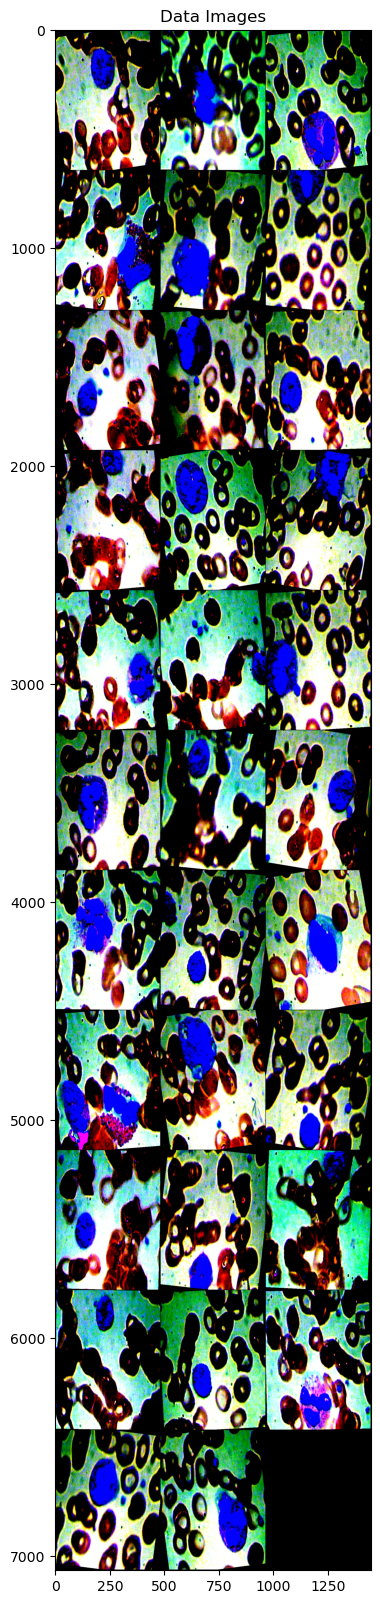

In [15]:
show_transformed_images(train_custom_dataset)

In [16]:
# Mini-Batch Gradient Descent

train_loader = torch.utils.data.DataLoader(train_custom_dataset, batch_size = 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_custom_dataset, batch_size = 32, shuffle=False)

In [17]:
def set_device():
    if torch.cuda.is_available() and torch.version.hip:
        dev = "cuda"
    elif torch.cuda.is_available() and torch.version.cuda:
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [18]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    
    # We trained the model but now what? 
    # We can save the best point in time before the model overfits
    best_acc = 0
    
    for epoch in range(n_epochs):
        print("Epoch number %d " % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
            
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total
        
        print("-    Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
              % (running_correct, total, epoch_acc, epoch_loss))
        
        test_dataset_acc = evaluate_model_on_test_set(model, test_loader)
        
        if(test_dataset_acc > best_acc):
            best_acc = test_dataset_acc
            save_checkpoint(model, epoch, optimizer, best_acc)
        
    # Make sure these are not in the for loop    
    print("Finished")
    return model

In [19]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval() # Set the model to evaluation mode
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            predicted_correctly_on_epoch += (predicted == labels).sum().item()
            
    epoch_acc = 100.00 * predicted_correctly_on_epoch / total
    print("    - Testing dataset. Got %d out of %d images correct (%.3f%%)"
          % (predicted_correctly_on_epoch, total, epoch_acc))
    # By returning epoch_acc we can store it for the train_nn func
    return epoch_acc

In [20]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    model_state = {
        'epoch' : epoch + 1,
        'model' : model.state_dict(),
        'best accuracy' : best_acc,
        'optimizer' : optimizer.state_dict(), 
    }
    torch.save(model_state, './Documents/Datasets/bloodCells/Complete-Blood-Cell-Count-Dataset-master/ModelCheckpoints/model_best_checkpoint.pth.tar')

In [21]:
# ResNet18 Model

import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# pretrained=True deprecated! 
# use weights for same effect
# pretrained vs not
resnet18_model =  models.resnet18(weights='DEFAULT')
num_ftrs = resnet18_model.fc.in_features
number_of_classes = test_number_of_classes
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet_18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

#Stochastic gradient descent
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

In [22]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 5)

Epoch number 1 
-    Training dataset. Got 185 out of 300 images correctly (61.667%). Epoch loss: 1.059
    - Testing dataset. Got 60 out of 60 images correct (100.000%)
Epoch number 2 
-    Training dataset. Got 218 out of 300 images correctly (72.667%). Epoch loss: 1.059
    - Testing dataset. Got 60 out of 60 images correct (100.000%)
Epoch number 3 
-    Training dataset. Got 221 out of 300 images correctly (73.667%). Epoch loss: 0.708
    - Testing dataset. Got 60 out of 60 images correct (100.000%)
Epoch number 4 
-    Training dataset. Got 249 out of 300 images correctly (83.000%). Epoch loss: 0.436
    - Testing dataset. Got 58 out of 60 images correct (96.667%)
Epoch number 5 
-    Training dataset. Got 265 out of 300 images correctly (88.333%). Epoch loss: 0.404
    - Testing dataset. Got 60 out of 60 images correct (100.000%)
Finished


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
checkpoint = torch.load('./Documents/Datasets/bloodCells/Complete-Blood-Cell-Count-Dataset-master/ModelCheckpoints/model_best_checkpoint.pth.tar')

In [28]:
# Check if our save file actually works and we can read it
print(checkpoint['epoch'])
print(checkpoint['best accuracy'])
# You can print the model to see what we will store in the next cell

1
100.0


In [ ]:
resnet18_model =  models.resnet18()
num_ftrs = resnet18_model.fc.in_features
number_of_classes = test_number_of_classes
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
resnet18_model.load_state_dict(checkpoint['model'])

torch.save(resnet18_model, './Documents/Datasets/bloodCells/Complete-Blood-Cell-Count-Dataset-master/ModelCheckpoints/best_model.pth')

In [ ]:
"""
What's next?


The testing image set is too low, and we can see this because the model consistently hits >95% immediately. 
There is an unused validation directory we can use in conjunction with the testing directory for our model
We can modify the program to run and classify single images


"""